In [0]:
# Importing the required libraries.

import json
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Downloading the dataset for sarcasm detection.

!wget --no-check-certificate \
https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
-O /tmp/sarcasm.json

--2020-06-16 22:26:14--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 2404:6800:4003:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.05s   

2020-06-16 22:26:15 (109 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [3]:
# Loading the dataset.

file = open('/tmp/sarcasm.json')
data = json.load(file)
file.close()

print(type(data), len(data))
data[:2]

<class 'list'> 26709


[{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5',
  'headline': "former versace store clerk sues over secret 'black code' for minority shoppers",
  'is_sarcastic': 0},
 {'article_link': 'https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365',
  'headline': "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
  'is_sarcastic': 0}]

In [0]:
# Building the training and testing datasets.

random.shuffle(data)

sentences, labels = [], []
for temp in data:
    sentences.append(temp['headline'])
    labels.append(temp['is_sarcastic'])

training_size = 20000
train_sentences, train_labels = sentences[:training_size], labels[:training_size]
test_sentences, test_labels = sentences[training_size:], labels[training_size:]

train_labels, test_labels = np.array(train_labels), np.array(test_labels)

Minimum length of a sentence in training data: 7
Maximum length of a sentence in training data: 237

Minimum length of a sentence in testing data: 9
Maximum length of a sentence in testing data: 254


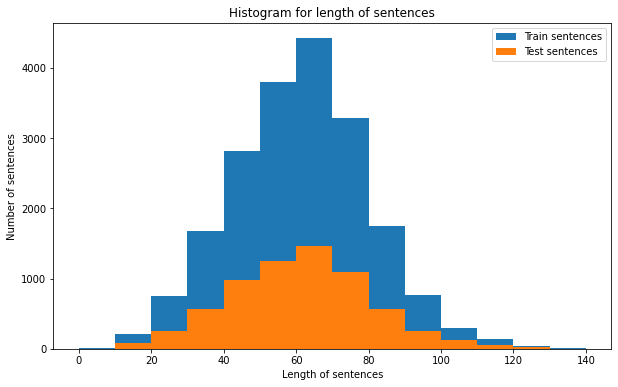

In [5]:
# Exploratory Data Analysis.

train_sentences_length, test_sentences_length = [], []
for sentence in train_sentences:
    train_sentences_length.append(len(sentence))
for sentence in test_sentences:
    test_sentences_length.append(len(sentence))

print('Minimum length of a sentence in training data:', min(train_sentences_length))
print('Maximum length of a sentence in training data:', max(train_sentences_length))
print()
print('Minimum length of a sentence in testing data:', min(test_sentences_length))
print('Maximum length of a sentence in testing data:', max(test_sentences_length))

plt.figure(figsize=(10,6))
bins = [10*i for i in range(15)]
plt.hist(train_sentences_length, bins=bins, label='Train sentences')
plt.hist(test_sentences_length, bins=bins, label='Test sentences')
plt.xlabel('Length of sentences')
plt.ylabel('Number of sentences')
plt.title('Histogram for length of sentences')
plt.legend()
plt.show()

In [0]:
# Function to build a model

def build_model(train_sentences, train_labels, test_sentences, test_labels, vocab_size=False, maxlen=100, 
                truncating='post', vector_dim=32, use_dropout=True, dropout_rate=0.5, average=False, epochs=5):

    # Tokenizing and padding the data.
    if vocab_size==False:
        tokenizer = Tokenizer(oov_token='<OOV>')
    else:
        tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
    tokenizer.fit_on_texts(train_sentences)
    vocab_size = len(tokenizer.word_index)
    print('Vocabulary size:', vocab_size)
    train_sentences_tokenized = tokenizer.texts_to_sequences(train_sentences)
    test_sentences_tokenized = tokenizer.texts_to_sequences(test_sentences)
    train_sentences_padded = pad_sequences(train_sentences_tokenized, maxlen=maxlen, truncating=truncating)
    test_sentences_padded = pad_sequences(test_sentences_tokenized, maxlen=maxlen, truncating=truncating)

    def add_dense(neurons):
        return tf.keras.layers.Dense(neurons, activation='relu')
    
    def add_flatten(average):
        if average:
            return tf.keras.layers.GlobalAveragePooling1D()
        return tf.keras.layers.Flatten()

    # Building a Neural Net model with Embedding layer.
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, vector_dim, input_length=maxlen),
        add_flatten(average),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.summary()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(train_sentences_padded, train_labels, 
              validation_data=(test_sentences_padded, test_labels), epochs=epochs)
    return model

In [7]:
model1 = build_model(train_sentences, train_labels, test_sentences, test_labels, 
                     average=False, vocab_size=20000, truncating='pre')

Vocabulary size: 25717
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 32)           822944    
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dropout (Dropout)            (None, 3200)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1638912   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_2 (Dense)              (Non

In [8]:
model2 = build_model(train_sentences, train_labels, test_sentences, test_labels, 
                     average=False, vocab_size=10000, truncating='pre')

Vocabulary size: 25717
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           822944    
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 3200)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1638912   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_5 (Dense)              (N

In [9]:
model3 = build_model(train_sentences, train_labels, test_sentences, test_labels, 
                     average=True, vocab_size=10000, truncating='post')

Vocabulary size: 25717
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 32)           822944    
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               16896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_8 (Dense)              (N

In [10]:
model4 = build_model(train_sentences, train_labels, test_sentences, test_labels, 
                     average=False, vocab_size=10000, truncating='pre')

Vocabulary size: 25717
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 32)           822944    
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 3200)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               1638912   
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_11 (Dense)             (N

In [11]:
model5 = build_model(train_sentences, train_labels, test_sentences, test_labels, 
                     average=False, vocab_size=5000, truncating='pre')

Vocabulary size: 25717
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 32)           822944    
_________________________________________________________________
flatten_3 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 3200)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               1638912   
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_14 (Dense)             (N